# Gradient Boosting

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
import timeit

In [2]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()
    
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

### Implementación

In [3]:
class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja del árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado al arbol regresor ht
           Además recibe el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        # Los multiplicadores son 1, luego el valor de la hoja no se actualiza
        return valor
    
    def predict(_, y):
        return y
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5*(y-F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        y_mean = np.mean(y)
        return 0.5*np.log((1.0+y_mean)/(1.0-y_mean))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return 2.0*y/(1+np.exp(2.0*y*F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        residuos_abs = np.abs(residuos)
        try:
            return np.sum(residuos)/np.sum(residuos_abs*(2.0-residuos_abs))
        except ZeroDivisionError:
            return 0.0
    
    def predict(_, y):
        return 2*((1.0/(1.0 + np.exp(-2 * y))) >= 0.5) - 1
        

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1+np.exp(-2.0*y*F))
    
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        class F0:
            predict = lambda x: self.loss.F0(X, y)
        self._estimators.append(F0)
        
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth = self.depth)
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            residuos = self.loss.residuos(y, self.predict(X))
            tree = tree.fit(X, residuos)
            self.paso_newton_general(tree, X, y, residuos)
            self._estimators.append(tree)
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """
        
        salida = sum(i.predict(X)*self.eta for i in self._estimators)
        return self.loss.predict(salida)   
            
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        self.leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = self.leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])



### Análisis de Gradient Boosting

#### Datos utilizados

Para realizar las pruebas se utilizarán como conjuntos de datos
- Para regresión: **diabetes** de Sklearn
- Para clasificación: **magic04.csv** y el siguiente conjunto de datos generado a partir de una sinusoidal:

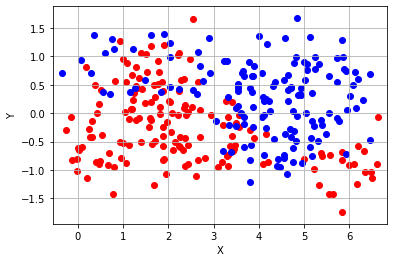

In [4]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3 
x1, x2, y_train, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
x1test, x2test, y_test = createDataSet(n*10, model, ymargin, noise)
plotData(x1,x2,y_train,{'c':'#FF0000'},{'c':'#0000FF'})
X_train = np.concatenate((x1, x2), axis = 1)
X_test = np.concatenate((x1test, x2test), axis = 1)

### Gradient Boosting para clasificación

A continuación, se calcula la precisión obtenida al clasificar los conjuntos de datos obtenidos a partir de una sinoidal y de 'magic04.csv' utilizando nuestro modelo Gradient Boosting y el modelo implementado en Sklearn, utilizando los mismos parámetros en ambos modelos.

Además, para el caso de los datos generados mediante una sinoidal, se ilustra la frontera de decisión. Para el conjunto de datos de 'magic04.csv' se ilustran los tiempos aproximados de entrenamiento y clasificación para ambos modelos. 

#### Utilizando Sine Data

Accuracy in Sine dataset with GBCasero = 0.8536666666666667


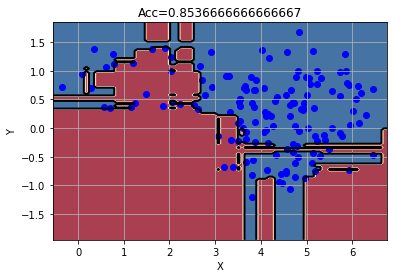

In [5]:
# Basic example
lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
y_train = lb.fit_transform(y_train).ravel()
y_test  = lb.transform(y_test).ravel()

gb = GBCasero(loss=LogLoss())
gb.fit(X_train, y_train)
acc = np.sum(gb.predict(X_test)==y_test)/len(y_test)

print("Accuracy in Sine dataset with GBCasero =",acc)
plotModel(x1,x2,y_train,gb,"Acc="+str(acc))

Accuracy in Sine dataset with GradientBoostingClassifier = 0.8556666666666667


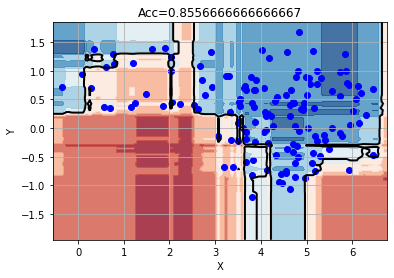

In [6]:
clf = GradientBoostingClassifier(n_estimators=101, learning_rate=0.1,max_depth=3)
clf.fit(X_train, y_train)
acc = np.sum(clf.predict(X_test)==y_test)/len(y_test)
print("Accuracy in Sine dataset with GradientBoostingClassifier =",acc)
plotModel(x1,x2,y_train,clf,"Acc="+str(acc))

#### Utilizando Magic04.csv

In [7]:
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_train, X_test, y_train, y_test = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.6, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_train = lb.fit_transform(y_train).ravel()
y_test = lb.transform(y_test).ravel()

print('GBCasero')
gb = GBCasero(loss=LogLoss())
tic = timeit.default_timer()
gb.fit(X_train, y_train)
toc = timeit.default_timer()
print("- Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)))
tic = timeit.default_timer()
acc =np.sum(gb.predict(X_test)==y_test)/len(y_test)
toc = timeit.default_timer()
print("- Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(len(X_test), (toc - tic)))
print("- Accuracy in Magic04 =",acc)


print('\nGradientBoostingClassifier')
clf = GradientBoostingClassifier(n_estimators=101, learning_rate=0.1,max_depth=3)
tic = timeit.default_timer()
clf.fit(X_train, y_train)
toc = timeit.default_timer()
print("- Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)))
tic = timeit.default_timer()
acc = clf.score(X_test, y_test)
toc = timeit.default_timer()
print("- Tiempo de clasificar {:g} ejemplos: {:.4g} s.".format(len(X_test), (toc - tic)))
print("- Accuracy in Magic04 =",acc)

GBCasero
- Tiempo de entrenamiento con 7608 ejemplos: 30.91 s.
- Tiempo de clasificar 11412 ejemplos: 0.8194 s.
- Accuracy in Magic04 = 0.8533999298983526

GradientBoostingClassifier
- Tiempo de entrenamiento con 7608 ejemplos: 2.645 s.
- Tiempo de clasificar 11412 ejemplos: 0.02726 s.
- Accuracy in Magic04 = 0.8671573781983877


### Gradient Boosting para regresión

A continuación, se calcula el coeficiente de determinación $R^2$ obtenido para las predicciones de los datos de diabetes de la librería sklearn utilizando nuestro modelo Gradient Boosting y el modelo implementado en Sklearn, utilizando los mismos parámetros en ambos modelos. Además, se ilustran los tiempos aproximados de entrenamiento y predicción para ambos modelos.

In [8]:
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

print('GBCasero')
gb = GBCasero(loss=SquaredErrorLoss())
tic = timeit.default_timer()
gb.fit(X_train, y_train)
toc = timeit.default_timer()
print("- Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)))
tic = timeit.default_timer()
mse = r2_score(y_test, gb.predict(X_test))
toc = timeit.default_timer()
factor = 100.
print("- Tiempo de predecir {:g} ejemplos: {:.4g} s.".format(len(X_test), (toc - tic)))
print("- Score in diabetes =",mse)

print('\nGradientBoostingRegressor')
clf = GradientBoostingRegressor(loss="ls",n_estimators=101, learning_rate=0.1,max_depth=3)
tic = timeit.default_timer()
clf.fit(X_train, y_train)
toc = timeit.default_timer()
print("- Tiempo de entrenamiento con {} ejemplos: {:.4g} s.".format(len(X_train),(toc - tic)))
tic = timeit.default_timer()
mse = clf.score(X_test, y_test)
toc = timeit.default_timer()
print("- Tiempo de predecir {:g} ejemplos: {:.4g} s.".format(len(X_test), (toc - tic)))
print("- Score in diabetes =",mse)

GBCasero
- Tiempo de entrenamiento con 309 ejemplos: 0.4918 s.
- Tiempo de predecir 133 ejemplos: 0.008044 s.
- Score in diabetes = 0.45456744177826525

GradientBoostingRegressor
- Tiempo de entrenamiento con 309 ejemplos: 0.07763 s.
- Tiempo de predecir 133 ejemplos: 0.001221 s.
- Score in diabetes = 0.4427130005422424


### Conclusiones

A la vista de los resultados obtenidos, podemos concluir que nuestro clasificador y regresor GBCasero obtiene un score competitivo con respecto al obtenido por SKlearn, ya que apenas difiere la precisión y el coeficiente de determinación $R^2$.

Sin embargo, el tiempo de cómputo que necesita nuestro modelo para entrenar el conjunto de datos de entrenamiento es mayor ($\sim 12.6$ veces superior para clasificación y $\sim 6.5$ veces superior para regresión) que el tiempo de cómputo del modelo de Sklearn. Esto puede deberse a que la implentación de Sklearn es mucho más eficiente que la nuestra. 